In [1]:
# Import dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import dependencies 
import numpy as np
import pandas as pd

In [3]:
# Import dependencies 
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()

In [16]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [20]:
# Get table names from database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [21]:
# Get column names from measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

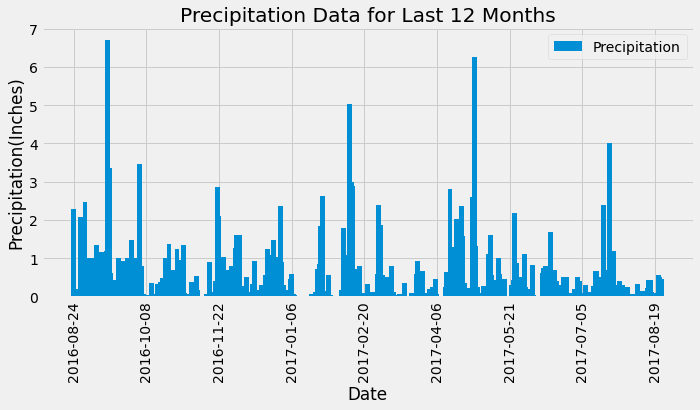

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Query for the dates in measurement table and list them in descending order to find the last date of recorded data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Create reference to last date and separate date into day, month and year elements
last_date = [int(last_date[0][:4]), int(last_date[0][5:7]), int(last_date[0][8:])]
# Calculate the date 1 year from the last date
year_ago = dt.date(last_date[0], last_date[1], last_date[2]) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
prcp_data = session.query(*sel).filter(Measurement.date > year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
dates = list(df.index.values)
precipitation = df['Precipitation']

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(dates, precipitation, width=3)

# Reduce number of x ticks
ticks = ax.get_xticks()
n = len(ticks)//8
ax.set_xticks(ticks[::n])

# Set axis and title labels, add legend and rotate x tick labels
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation(Inches)")
ax.set_title("Precipitation Data for Last 12 Months")
fig.tight_layout()
plt.xticks(rotation=90)
plt.legend(['Precipitation'])

plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = df.describe()
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = stations[0][0]

lowest_temp = session.query(func.min(Measurement.tobs)).filter_by(station = most_active_station).first()
highest_temp = session.query(func.max(Measurement.tobs)).filter_by(station = most_active_station).first()
avg_temp = session.query(func.round(func.avg(Measurement.tobs),2)).filter_by(station = most_active_station).first()

print(f'The lowest recorded temperature is {lowest_temp[0]} degrees Fahrenheit.')
print(f'The highest recorded temperature is {highest_temp[0]} degrees Fahrenheit.')
print(f'The average temperature is {avg_temp[0]} degrees Fahrenheit.')

The lowest recorded temperature is 54.0 degrees Fahrenheit.
The highest recorded temperature is 85.0 degrees Fahrenheit.
The average temperature is 71.66 degrees Fahrenheit.


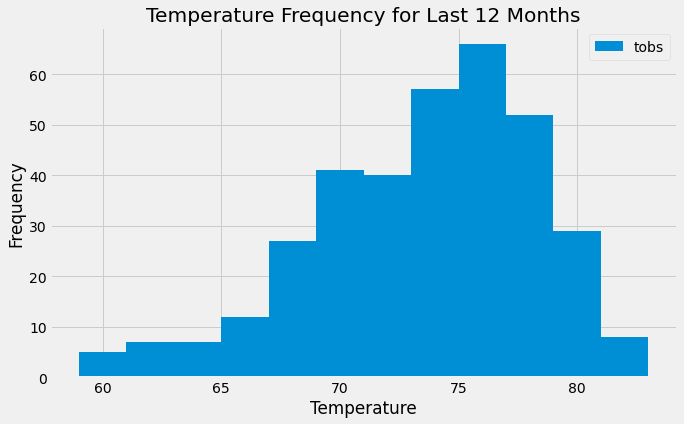

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = session.query(Measurement.date, Measurement.tobs).\
    filter_by(station = most_active_station).\
    filter(Measurement.date > year_ago).all()

# Create a dataframe using the results from above query
temps_df = pd.DataFrame(last_year_temps)

# Set values and plot histogram with 12 bins
values = temps_df['tobs']

hist = values.hist(bins=12, figsize=(10,6))

# Add labels and legend to plot
hist.set_title('Temperature Frequency for Last 12 Months')
hist.set_xlabel('Temperature')
hist.set_ylabel('Frequency')
hist.legend(['tobs'])
plt.show()

## Bonus Challenge Assignment

In [28]:
jun_avg_temps = session.query(func.round(func.avg(Measurement.tobs),2)).filter(func.strftime("%m", Measurement.date) == '06').all()
dec_avg_temps = session.query(func.round(func.avg(Measurement.tobs),2)).filter(func.strftime("%m", Measurement.date) == '12').all()

print(f'The average temp in June is {jun_avg_temps[0][0]}.')
print(f'The average temp in December is {dec_avg_temps[0][0]}.')

The average temp in June is 74.94.
The average temp in December is 71.04.


In [29]:
from scipy.stats import ttest_ind

jun_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()
dec_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()

jun_temps = np.ravel(jun_temps).tolist()
dec_temps = np.ravel(dec_temps).tolist()

ttest = ttest_ind(jun_temps, dec_temps)
ttest

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

The pvalue is less than alpha=0.05 so the difference is statistically significant. A paired t-test would be used because we are comparing the temperatures of the same place.

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_temps = calc_temps('2016-12-01', '2016-12-08')
my_trip_temps= np.ravel(my_trip_temps).tolist()
my_trip_temps

[67.0, 71.50943396226415, 77.0]

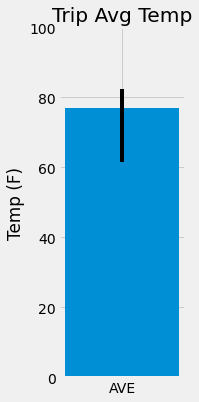

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_labels = ['AVE']
fig, ax = plt.subplots(figsize=(2,6))
yerr = my_trip_temps[2]-my_trip_temps[1]
ax.bar(x_labels, my_trip_temps, yerr=yerr)

ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
ax.set_ylim(0, 100)
plt.show()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

my_trip_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-12-01').\
    filter(Measurement.date <= '2016-12-08').\
    group_by(Station.name).\
    order_by(func.sum(Measurement.prcp).desc()).all()

df = pd.DataFrame(my_trip_rain, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Total Rainfall'])
df

,Station,Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.57
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.94
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.33
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.04
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.95
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.66
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.27


In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2020-12-01'
end = '2020-12-08'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start='2020-12-01', end='2020-12-08', freq='d')

# Stip off the year and save a list of %m-%d strings
# trip_dates = [str(date)[5:10] for date in trip_dates]
stripped_trip_dates = trip_dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date)[0] for date in stripped_trip_dates]
normals

[(65.0, 71.91666666666667, 78.0),
 (62.0, 71.32692307692308, 77.0),
 (67.0, 72.88679245283019, 79.0),
 (66.0, 72.17647058823529, 81.0),
 (64.0, 70.92156862745098, 78.0),
 (61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['TMIN', 'TAVG', 'TMAX'])
df['Date'] = trip_dates.strftime("%y-%m-%d")
df = df[['Date', 'TMIN', 'TAVG', 'TMAX']]
df.set_index('Date', inplace=True)
df

,TMIN,TAVG,TMAX
Date,,,
20-12-01,65.0,71.916667,78.0
20-12-02,62.0,71.326923,77.0
20-12-03,67.0,72.886792,79.0
20-12-04,66.0,72.176471,81.0
20-12-05,64.0,70.921569,78.0
20-12-06,61.0,69.392157,78.0
20-12-07,58.0,69.200000,79.0
20-12-08,60.0,70.274510,83.0


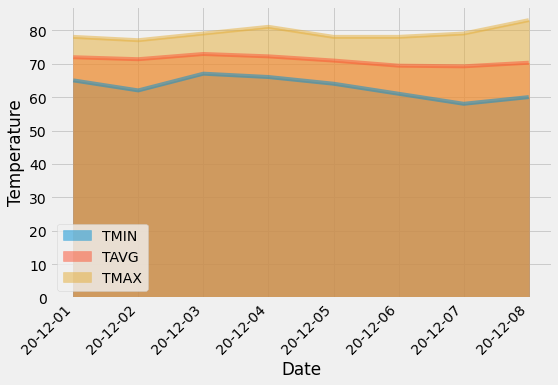

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df.plot.area(stacked=False, figsize=(8,5))
ax.set_ylabel('Temperature')
plt.xticks(rotation=45, ha='right')
plt.show()